In [2]:
import tensorflow as tf
import numpy as np
from google.colab import auth
from google.cloud import storage
import time
from datetime import datetime
from dateutil.parser import parse
from datetime import timedelta
import matplotlib.pyplot as plt
import os
from tensorflow import keras
from tensorflow.keras import layers

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from drive.MyDrive.fire_ml.fire_ml.models import AttentionEncoderDecoder

ImportError: ignored

In [ ]:
auth.authenticate_user() #Google User Authentication
BUCKET = "naal_fire"
PROJECT_ID = "fire-278302"
!gcloud config set project {PROJECT_ID}

Updated property [core/project].


In [ ]:
def import_data(set_type: str, bucket: str):
  if not os.path.exists("/tmp/"):
    print("tmp directory did not exist")
    os.mkdir("/tmp")
  if set_type == "val":
    fname = "val_fires.npy"
  elif set_type == "test":
    fname = "test_fires.npy"
  else:
    fname = "train_fires.npy"

  bucket_link = "gs://naal_fire/fire_data_numpy/" + fname
  command = "gsutil cp " + bucket_link + " /tmp/data_item2.npy"
  os.system(command)
  loaded_data = np.load("/tmp/data_item2.npy", allow_pickle=True)

  return loaded_data

In [ ]:
train_data = import_data("train", BUCKET)
val_data = import_data("val", BUCKET)
test_data = import_data("test", BUCKET)

In [ ]:
train_data.shape

(1460, 2)

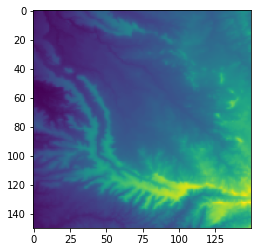

In [ ]:
item_1 = train_data[2]
item_1_standard = (item_1[0][0][:,:,0]-(-20.1))/(2832.102295-(-20.1))
plt.imshow(item_1_standard)

In [ ]:
print(np.amax(item_1[0][0][:,:,0]))
print(np.amax(item_1_standard))

304.66156005859375
0.1138634383079738


141.0
0.11380120607744994


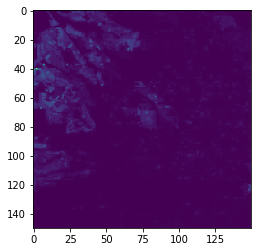

In [ ]:
plt.imshow(item_1[0][0][:,:,1]/1239.002686)
print(np.amax(item_1[0][0][:,:,1]))
print(np.amax(item_1[0][0][:,:,1]/1239.002686))

In [ ]:
def compile_dataset(data: np.ndarray, normalize=True):
  data_lines = data[:, 0]
  labels_orig = data[:, 1]
  labels = []
  topo_pop_imgs = []
  ghm_imgs = []
  soil_mois_sequences = []
  wind_data_set = []

  topo_pop_min = np.asarray([-20.090999603271484, 0])
  wind_subtract = np.asarray([2.34576076948354, 10.7794731403126, 1.34830699602154])
  wind_devide = np.asarray([1.09209464421014, 3.43217530043941, (5.86155835839451-1.34830699602154)])

  for di, data_line in enumerate(data_lines):
    topo_pop_img = data_line[0]
    ghm_img = data_line[1]
    soil_mois = data_line[2]
    wind_data = data_line[3]

    soil_mois_none_count = np.sum(np.isnan(soil_mois.astype(float)))

    if soil_mois_none_count == 0:
      topo_pop_imgs.append(topo_pop_img)
      ghm_imgs.append(data_line[1])
      soil_mois_sequences.append(data_line[2])
      wind_data_set.append(data_line[3])
      labels.append(labels_orig[di])
  
  topo_pop_imgs = np.asarray(topo_pop_imgs)
  ghm_imgs = np.asarray(ghm_imgs)
  soil_mois_sequences = np.asarray(soil_mois_sequences)
  wind_data_set = np.asarray(wind_data_set)
  labels = np.asarray(labels)

  if normalize:
    topo_pop_imgs = (topo_pop_imgs - topo_pop_min) / np.asarray([2852.1932945251465, 1239.002685546875])
    ghm_imgs = (ghm_imgs - 0.412004231100664) / 0.23914748951343515
    soil_mois_sequences = (soil_mois_sequences - np.asarray([0.29586066306320585, 0.29586066306320585, 0.29586066306320585, 52.63339493972673])) / np.asarray([0.09639456520589082, 0.09639456520589082, 0.09639456520589082, 50.17451237546779])
    wind_data_set = (wind_data_set - np.asarray([2.3719584472745887, 10.819944739833659, 0])) / np.asarray([1.1081678371741006, 3.427114314159214, 6.28318530718])
  
  inputs = {
      "topology_population_img": topo_pop_imgs,
      "human_modification_img": ghm_imgs,
      "soil_moisture_series": soil_mois_sequences,
      "wind_speed_gust_dir": wind_data_set
  }

  dataset = tf.data.Dataset.from_tensor_slices((inputs, labels))

  return dataset

In [ ]:
train_dataset = compile_dataset(train_data).shuffle(buffer_size=1453).batch(32)
val_dataset = compile_dataset(val_data).batch(78)
test_dataset = compile_dataset(test_data)

In [ ]:
def get_combined_model():
  topo_pop_input = keras.Input(shape=(150, 150, 2), name="topology_population_img")
  ghm_input = keras.Input(shape=(15, 15), name="human_modification_img")
  soil_input = keras.Input(shape=(12, 4), name="soil_moisture_series")
  wind_input = keras.Input(shape=(3,), name="wind_speed_gust_dir")

  x = layers.LSTM(16)(soil_input)

  y = layers.Conv2D(16, 3, padding="same", activation="relu")(topo_pop_input)
  y = layers.BatchNormalization()(y)
  y = layers.MaxPool2D()(y)
  y = layers.Conv2D(32, 3, activation="relu")(y)
  y = layers.BatchNormalization()(y)
  y = layers.MaxPool2D()(y)
  y = layers.Conv2D(64, 3, activation='relu')(y)
  y = layers.BatchNormalization()(y)
  y = layers.MaxPool2D()(y)
  y = layers.Conv2D(124, 3, activation='relu')(y)
  y = layers.BatchNormalization()(y)

  ghm_r = layers.Reshape((15, 15, 1))(ghm_input)
  topo_pop_ghm = layers.concatenate([y, ghm_r])

  z = layers.Conv2D(256, 3, padding="same", activation='relu')(topo_pop_ghm)
  s = layers.BatchNormalization()(z)
  z = layers.Conv2D(512, 3, padding="same", activation='relu')(s)
  z = layers.BatchNormalization()(z)
  z = layers.Conv2D(650, 3, padding="same", activation='relu')(z)
  z = layers.BatchNormalization()(z)
  z = layers.Conv2D(756, 3, padding="same", activation='relu')(z)
  z = layers.BatchNormalization()(z)
  z = layers.Conv2D(1024, 3, padding="same", activation=None)(z)
  z = layers.concatenate([z, s])
  z = layers.Activation("relu")(z)
  z = layers.BatchNormalization()(z)
  z = layers.SeparableConv2D(256, 3)(z)

  w = layers.Flatten()(z)
  all_data = layers.concatenate([x, w, wind_input])
  d = layers.Dense(512, activation="relu")(all_data)
  output = layers.Dense(1)(d)

  model = keras.Model(inputs=[topo_pop_input, ghm_input, soil_input, wind_input],
                      outputs=output)
  
  return model

In [ ]:
def get_lstm_branch(lstm_units: int, dense_units: int, dense_layers=1):
  soil_input = keras.Input(shape=(12, 4), name="soil_moisture_series")
  x = layers.GRU(lstm_units)(soil_input)
  x = layers.Dropout(.5)(x)
  d = layers.Dense(dense_units, activation="relu")(x)
  if dense_layers > 1:
    for dense_layer in range(dense_layers-1):
      d = layers.Dense(dense_units, activation="relu")(d)
  output = layers.Dense(1)(d)

  model = keras.Model(inputs=[soil_input],
                      outputs=output)
  
  return model

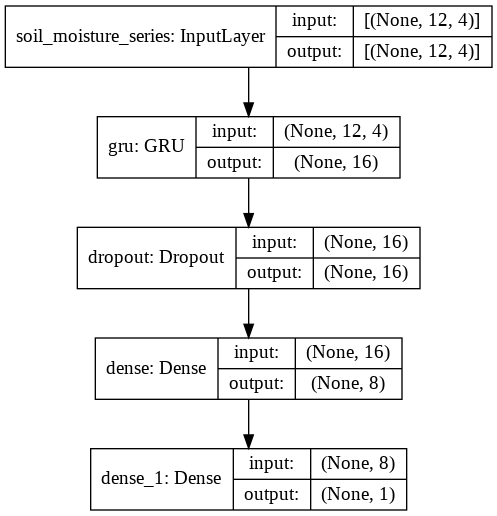

In [ ]:
model7 = get_lstm_branch(16, 8, dense_layers=1)
keras.utils.plot_model(model7, "gru.png", show_shapes=True)

In [ ]:
model7.compile(optimizer=keras.optimizers.Adam(),
              loss=[keras.losses.BinaryCrossentropy(from_logits=True)],
              metrics=['accuracy', tf.keras.metrics.BinaryAccuracy()])

In [ ]:
history7 = model7.fit(x=train_dataset, epochs=800, validation_data=val_dataset)

Epoch 1/800


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['topology_population_img', 'human_modification_img', 'wind_speed_gust_dir'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


46/46 [==============================] - 32s 26ms/step - loss: 0.7276 - accuracy: 0.4914 - binary_accuracy: 0.4914 - val_loss: 0.6672 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 2/800
46/46 [==============================] - 1s 9ms/step - loss: 0.6841 - accuracy: 0.5066 - binary_accuracy: 0.5066 - val_loss: 0.6383 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 3/800
46/46 [==============================] - 1s 9ms/step - loss: 0.6682 - accuracy: 0.5117 - binary_accuracy: 0.5117 - val_loss: 0.6245 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 4/800
46/46 [==============================] - 1s 9ms/step - loss: 0.6532 - accuracy: 0.5055 - binary_accuracy: 0.5055 - val_loss: 0.6152 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 5/800
46/46 [==============================] - 1s 8ms/step - loss: 0.6526 - accuracy: 0.5016 - binary_accuracy: 0.5016 - val_loss: 0.6025 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 6/800
46/46 [======

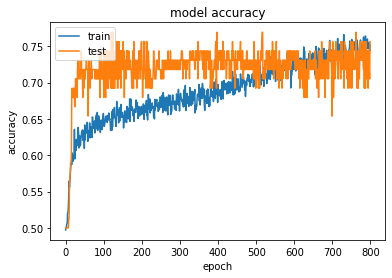

In [ ]:
# lstm - 16, dense - 16
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# lstm - 8, dense - 8
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: ignored

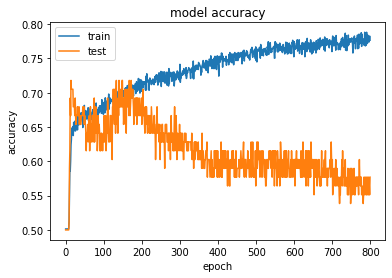

In [ ]:
# lstm -8, dense - 8 x2
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

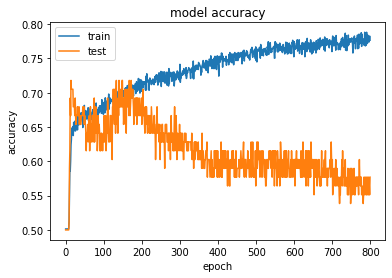

In [ ]:
# lstm - 16, dense - 16, 8
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

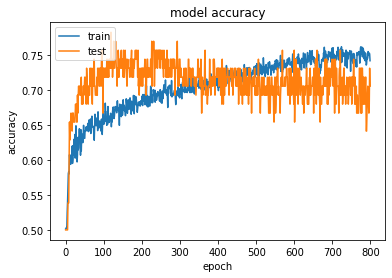

In [ ]:
# lstm - 16, dense - 16, 8
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

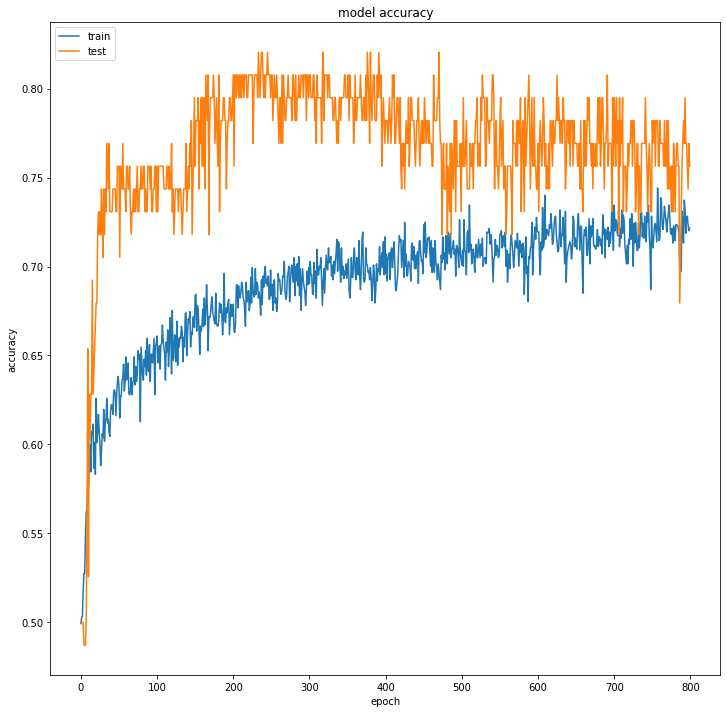

In [ ]:
# lstm - 16, dense - 8, dropout - .5
plt.figure(figsize=(12, 12))
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
np.mean(np.asarray(history5.history['val_accuracy'])[100:])

0.775494503549167

In [ ]:
tf.saved_model.save(model5, "LSTM_model_w_dropout")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: LSTM_model_w_dropout/assets


In [ ]:
import os
import zipfile

def zipdir(path, ziph):
    # ziph is zipfile handle
    for root, dirs, files in os.walk(path):
        for file in files:
            ziph.write(os.path.join(root, file))

zipf = zipfile.ZipFile('lstm_fire_model.zip', 'w', zipfile.ZIP_DEFLATED)
zipdir('/content/LSTM_model_w_dropout', zipf)
zipf.close()

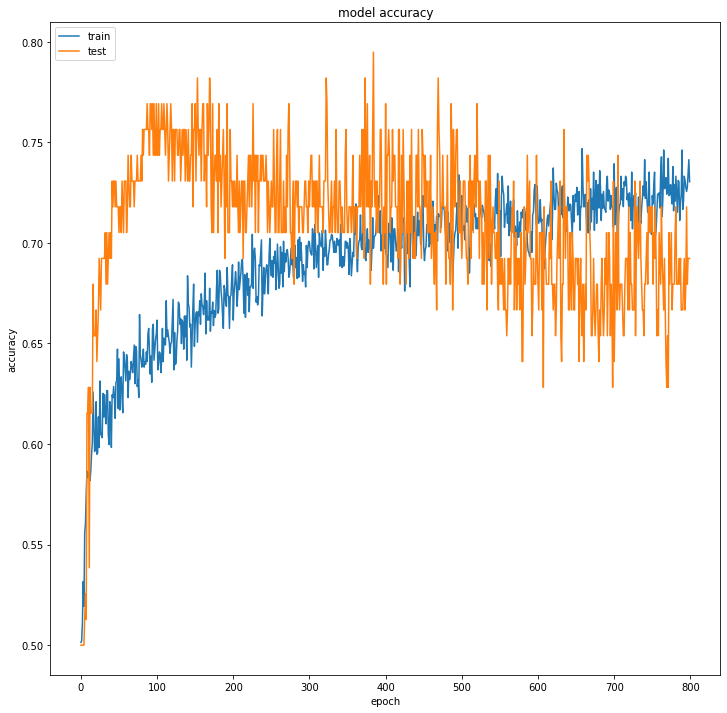

In [ ]:
# lstm - 16, dense - 8, dropout - .5
plt.figure(figsize=(12, 12))
plt.plot(history6.history['accuracy'])
plt.plot(history6.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

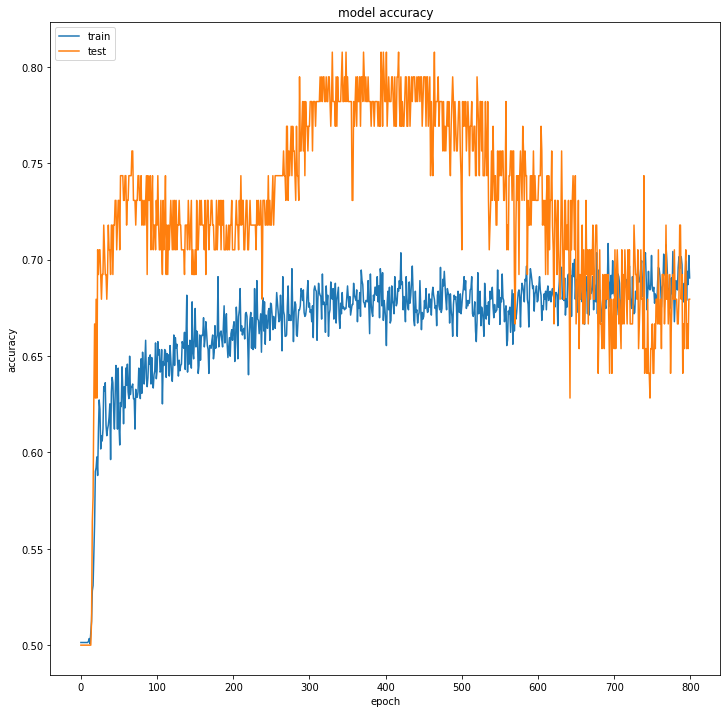

In [ ]:
# GRU - 16, dense - 8, dropout - .5
plt.figure(figsize=(12, 12))
plt.plot(history7.history['accuracy'])
plt.plot(history7.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
def get_wind_branch(dense_units: int, hidden_layers: int, double_second=False):
  wind_input = keras.Input(shape=(3,), name="wind_speed_gust_dir")
  for i in range(hidden_layers):
    if i > 0:
      d = layers.Dropout(.5)(d)
    if i < 1:
      d = layers.Dense(dense_units, activation="relu")(wind_input)
    elif i < 2 and double_second:
      d = layers.Dense(dense_units*2, activation="relu")(d)
    else:
      d = layers.Dense(dense_units, activation="relu")(d)
  
  output = layers.Dense(1)(d)

  model = keras.Model(inputs=[wind_input],
                      outputs=output)
  
  return model

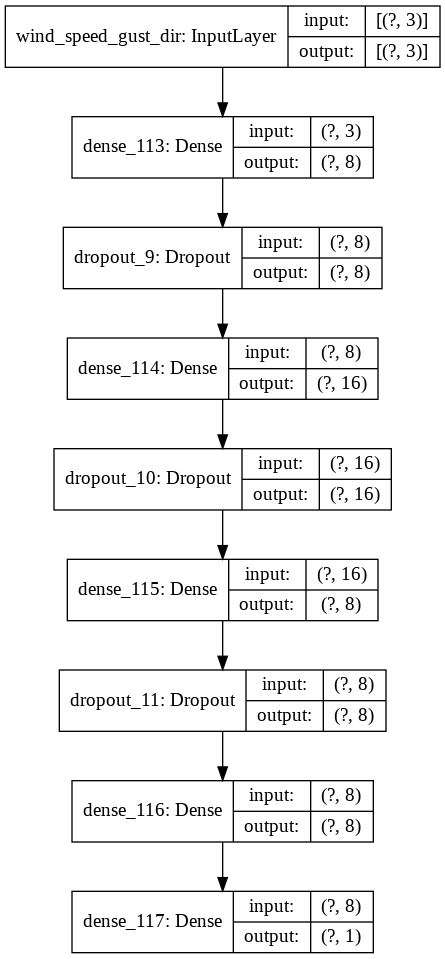

In [ ]:
wind_model = get_wind_branch(8, 4, double_second=True)
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = keras.optimizers.Adam()
wind_model.compile(optimizer=optimizer,
              loss=[keras.losses.BinaryCrossentropy(from_logits=True)],
              metrics=['accuracy', tf.keras.metrics.BinaryAccuracy()])
keras.utils.plot_model(wind_model, "gru.png", show_shapes=True)

In [ ]:
windhistory = wind_model.fit(x=train_dataset, epochs=3000, validation_data=val_dataset)

Epoch 1/3000


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:543: UserWarning: Input dict contained keys ['topology_population_img', 'human_modification_img', 'soil_moisture_series'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


Streaming output truncated to the last 5000 lines.
46/46 [==============================] - 0s 9ms/step - loss: 0.6803 - accuracy: 0.5014 - binary_accuracy: 0.5014 - val_loss: 0.6848 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 502/3000
46/46 [==============================] - 0s 9ms/step - loss: 0.6800 - accuracy: 0.5014 - binary_accuracy: 0.5014 - val_loss: 0.6849 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 503/3000
46/46 [==============================] - 0s 9ms/step - loss: 0.6842 - accuracy: 0.5014 - binary_accuracy: 0.5014 - val_loss: 0.6863 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 504/3000
46/46 [==============================] - 0s 9ms/step - loss: 0.6786 - accuracy: 0.5014 - binary_accuracy: 0.5014 - val_loss: 0.6855 - val_accuracy: 0.5000 - val_binary_accuracy: 0.5000
Epoch 505/3000
46/46 [==============================] - 0s 9ms/step - loss: 0.6857 - accuracy: 0.5014 - binary_accuracy: 0.5014 - val_loss: 0.6856 - val_accuracy: 0